# 调用必备库

In [ ]:
import PyQt5

In [ ]:
%matplotlib qt5

In [1]:
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

#np.random.seed(42)
#torch.manual_seed(42)

# 先随便搭建个简单的神经网络


## 神经网络求解

In [2]:
class zsrDGM_net(nn.Module):
    def __init__(self,numl,numn):
        # numl是有多少层隐藏层
        # numn是每层的神经元数量
        super(zsrDGM_net, self).__init__()
        self.input_layer = nn.Linear(3, numn)#前面的数字代表几个输入
        self.hidden_layers = nn.ModuleList([nn.Linear(numn, numn) for i in range(numl)])
        self.output_layer = nn.Linear(numn, 1)
    def forward(self, x):
        o = self.act(self.input_layer(x))
        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))        
        out = self.output_layer(o)        
        return out
    def act(self, x):
        return x * torch.tanh(x)

In [3]:
class PDE():
    def __init__(self, net,t,size):
        self.net=net
        self.t=t
        self.size=size
    def sample(self):
        size=self.size
        sp = torch.cat((torch.full([N1*size, 1], 0) + torch.rand([N1*size, 1]) * np.pi,torch.full([N1*size, 1], 0) + torch.rand([N1*size, 1]) * np.pi,torch.rand([N1*size, 1]) * self.t), dim=1)
        sp_x = torch.full([N2*size, 1], 0) + torch.rand([N2*size, 1]) * np.pi
        sp_y = torch.full([N2*size, 1], 0) + torch.rand([N2*size, 1]) * np.pi
        sp_initial = torch.cat((sp_x,sp_y,torch.zeros(N2*size, 1)), dim=1)
        x_boundary_left = torch.cat(( torch.full([N3*size, 1], 0),torch.rand([N3*size, 1])*np.pi,torch.rand([N3*size, 1])*self.t), dim=1)
        x_boundary_right = torch.cat(( torch.full([N3*size, 1], np.pi),torch.rand([N3*size, 1])*np.pi,torch.rand([N3*size, 1])*self.t), dim=1)
        y_boundary_left = torch.cat(( torch.rand([N3*size, 1])*np.pi,torch.full([N3*size, 1], 0),torch.rand([N3*size, 1])*self.t), dim=1)
        y_boundary_right = torch.cat(( torch.rand([N3*size, 1])*np.pi,torch.full([N3*size, 1], np.pi),torch.rand([N3*size, 1])*self.t), dim=1)       
        return sp, sp_initial, sp_x,sp_y,x_boundary_left, x_boundary_right,y_boundary_left, y_boundary_right
    def loss_func(self):
        size=self.size
        sp_train, sp_initial, sp_x,sp_y,x_boundary_left, x_boundary_right,y_boundary_left, y_boundary_right = self.sample()
        sp = Variable(sp_train, requires_grad=True)
        d = torch.autograd.grad(net(sp), sp, grad_outputs=torch.ones_like(net(sp)), create_graph=True)
        dx = d[0][:, 0].unsqueeze(-1)
        dy = d[0][:, 1].unsqueeze(-1)
        dt = d[0][:, 2].unsqueeze(-1)
        dxx = torch.autograd.grad(dx, sp, grad_outputs=torch.ones_like(dx), create_graph=True)[0][:, 0].unsqueeze(-1)
        dyy = torch.autograd.grad(dy, sp, grad_outputs=torch.ones_like(dy), create_graph=True)[0][:, 1].unsqueeze(-1)
        loss_fn = nn.MSELoss(reduction='mean')
        loss1 = loss_fn(dt, 1/2*(dxx+dyy))
        loss2 = loss_fn(net(sp_initial), torch.zeros([N2*size,1])+np.sin(sp_x)*np.sin(sp_y))
        loss3 = loss_fn(net(x_boundary_left), torch.zeros([N3*size,1])+torch.full([N3*size, 1], 0))
        loss4 = loss_fn(net(x_boundary_right),torch.zeros([N3*size,1])+torch.full([N3*size, 1], 0))
        loss5 = loss_fn(net(y_boundary_left), torch.zeros([N3*size,1])+torch.full([N3*size, 1], 0))
        loss6 = loss_fn(net(y_boundary_right),torch.zeros([N3*size,1])+torch.full([N3*size, 1], 0))
        loss = loss1 + loss2 + loss3 + loss4 +loss5 +loss6
        #print(loss1,loss2,loss3,loss4)
        return loss
        
        

In [4]:
class Train():
    def __init__(self, net, eq, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = eq
    def train(self, epoch, lr):
        optimizer = optim.Adam(self.net.parameters(), lr)
        avg_loss = 0
        print('epoch start')
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func()
            avg_loss = avg_loss + float(loss.item())
            loss.backward()
            optimizer.step()
            if e % 100 == 99:
                loss = avg_loss/100
                print("Epoch {} - lr {} -  loss: {}".format(e, lr, loss))
                avg_loss = 0
                error = self.model.loss_func()
                self.errors.append(error.detach())
    def get_errors(self):
        return self.errors

# 这个是训练的代码，不用跑

In [5]:
net = zsrDGM_net(numl=6, numn=150)
t=2.3
N1=4
N2=1
N3=2
size=2**11
equation = PDE(net,t,size)
train = Train(net, equation, BATCH_SIZE=size)
train.train(epoch=1000, lr=0.001)
torch.save(net, 'test5.pkl')
errors = train.get_errors()

epoch start
Epoch 99 - lr 0.001 -  loss: 0.23053910091519356
Epoch 199 - lr 0.001 -  loss: 0.16178045354783535
Epoch 299 - lr 0.001 -  loss: 0.029572569413576274
Epoch 399 - lr 0.001 -  loss: 0.003452980117290281
Epoch 499 - lr 0.001 -  loss: 0.0003918360584066249
Epoch 599 - lr 0.001 -  loss: 0.00018855569025618023
Epoch 699 - lr 0.001 -  loss: 0.00015136442743823864
Epoch 799 - lr 0.001 -  loss: 0.00012663030487601644
Epoch 899 - lr 0.001 -  loss: 0.00011381339270883473
Epoch 999 - lr 0.001 -  loss: 0.0001583670702893869


直接跑下面这个

In [6]:
x = [[i/100] for i in range(0,314)]
y = torch.tensor([[i/100] for i in range(0,314)])
Z=[]
for i in x:
    u = torch.cat((torch.full([314, 1],i[0]),y,torch.full([314, 1],0)), dim=1)
    net=torch.load('test5.pkl')
    usolve=net(u)
    usolve=usolve.detach().numpy()
    Z.append(usolve)

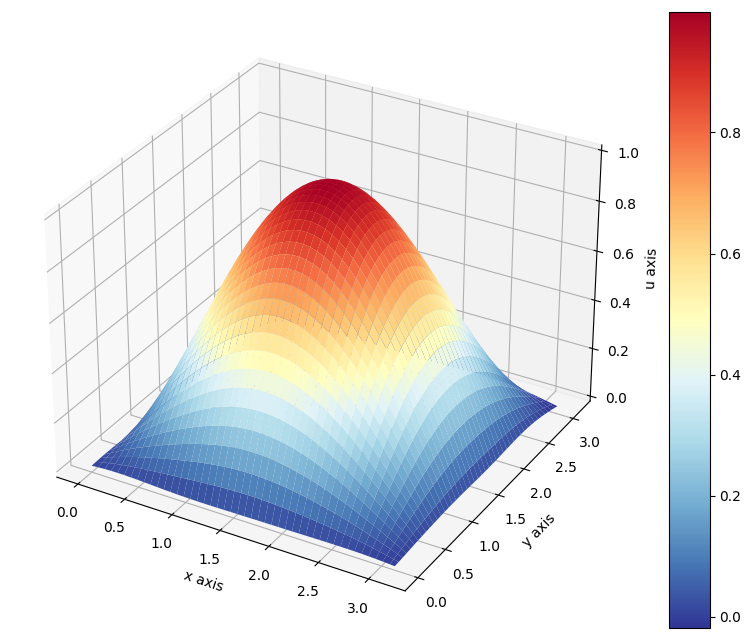

In [7]:
xd=np.array([[i/100] for i in range(0,314)])
yd=np.array([[i/100] for i in range(0,314)])
_X, _Y = np.meshgrid(xd, yd, indexing='ij')
True_Z_surface1 = np.reshape(Z, (xd.shape[0], yd.shape[0]))
fig = plt.figure(figsize=(10, 10), facecolor='white') #创建图片
sub = fig.add_subplot(111, projection='3d')# 添加子图，
sub.set_zlim([0, 1])
#ax = fig.gca(projection='3d')
surf=sub.plot_surface(_X, _Y, True_Z_surface1, cmap=plt.cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
cb = fig.colorbar(surf, shrink=0.8, aspect=15) #设置颜色棒
sub.set_xlabel(r"x axis")
sub.set_ylabel(r"y axis")
sub.set_zlabel(r"u axis")
plt.show()

In [10]:
x = [[i/100] for i in range(0,314)]
y = torch.tensor([[i/100] for i in range(0,314)])
Z=[]
for i in x:
    u = torch.cat((torch.full([314, 1],i[0]),y,torch.full([314, 1],2)), dim=1)
    net=torch.load('test5.pkl')
    usolve=net(u)
    usolve=usolve.detach().numpy()
    Z.append(usolve)

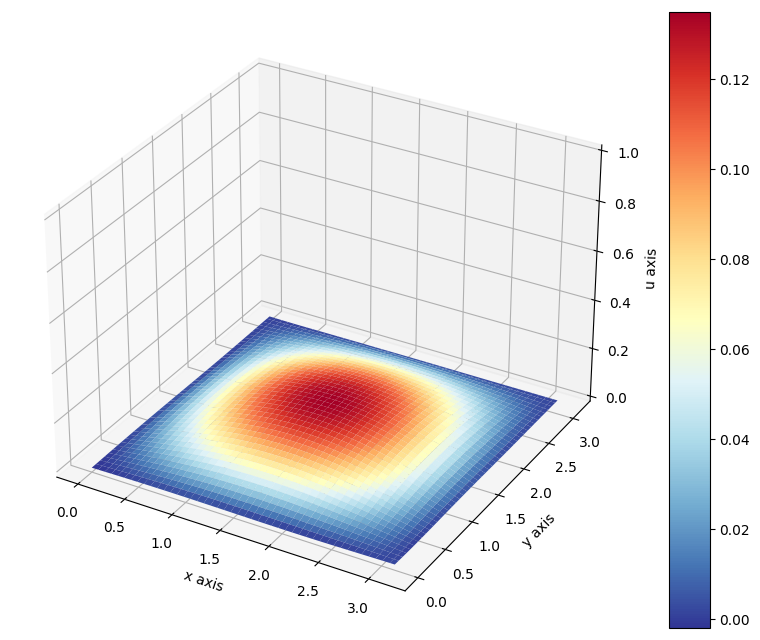

In [11]:
xd=np.array([[i/100] for i in range(0,314)])
yd=np.array([[i/100] for i in range(0,314)])
_X, _Y = np.meshgrid(xd, yd, indexing='ij')
True_Z_surface2 = np.reshape(Z, (xd.shape[0], yd.shape[0]))
fig = plt.figure(figsize=(10, 10), facecolor='white') #创建图片
sub = fig.add_subplot(111, projection='3d')# 添加子图，
sub.set_zlim([0, 1])
#ax = fig.gca(projection='3d')
surf=sub.plot_surface(_X, _Y, True_Z_surface2, cmap=plt.cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
cb = fig.colorbar(surf, shrink=0.8, aspect=15) #设置颜色棒
sub.set_xlabel(r"x axis")
sub.set_ylabel(r"y axis")
sub.set_zlabel(r"u axis")
plt.show()

In [15]:
print(max(Z[147]))

IndexError: list index out of range

In [13]:
np.exp(-2)

0.1353352832366127

# 误差曲线绘制

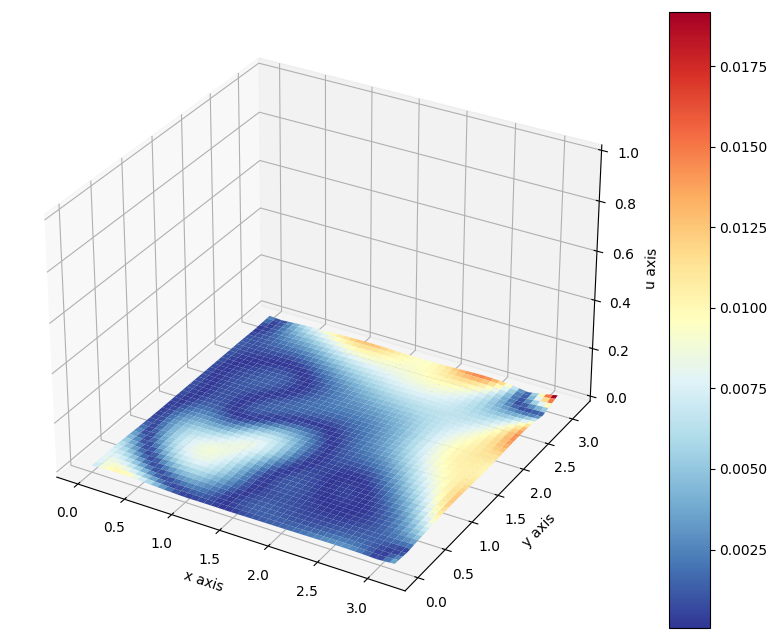

0.9999748146823376


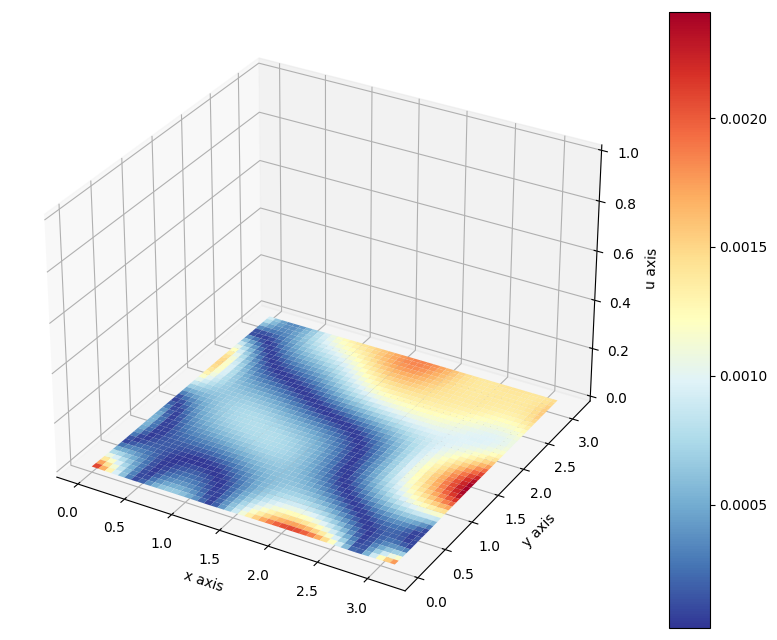

0.13533187477451347


In [14]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  5 10:30:47 2022

@author: HEYIMANQI
"""


import matplotlib.pyplot as plt
import numpy as np
from math import *
from mpl_toolkits.mplot3d import Axes3D
import torch
from matplotlib import cm
te = 2
xe = pi
ye = pi
#t_range = np.linspace(0, te, 2, dtype=np.float64)
t_range=np.array([0,2])
x_range = np.linspace(0, xe, 314, dtype=np.float64)
y_range = np.linspace(0, ye, 314, dtype=np.float64)
data = np.empty((3, 1))
k = 0
for _t in t_range:
    TrueZ = []
    Z = []
    data[0] = _t
    for _x in x_range:
        data[1] = _x
        for _y in y_range:
            data[2] = _y
            indata = torch.Tensor(data.reshape(1, -1))
            TrueZ.append(np.exp(-(_t))*np.sin(_x)*np.sin(_y))

    _X, _Y = np.meshgrid(x_range, y_range, indexing='ij')
    if _t==0:
        True_Z_surface = abs(np.reshape(TrueZ, (x_range.shape[0], y_range.shape[0]))-True_Z_surface1)
    elif _t==2:
        True_Z_surface = abs(np.reshape(TrueZ, (x_range.shape[0], y_range.shape[0]))-True_Z_surface2)
    
    
   
    # plot the exact solution
    
    fig = plt.figure(figsize=(10, 10), facecolor='white') #创建图片
    sub = fig.add_subplot(111, projection='3d')# 添加子图，
    sub.set_zlim([0, 1])
    #ax = fig.gca(projection='3d')
    surf=sub.plot_surface(_X, _Y, True_Z_surface, cmap=plt.cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
    cb = fig.colorbar(surf, shrink=0.8, aspect=15) #设置颜色棒
    sub.set_xlabel(r"x axis")
    sub.set_ylabel(r"y axis")
    sub.set_zlabel(r"u axis")
    path = "%i.png" % k
    plt.show()
    plt.close(fig)
    print(max(TrueZ))
    k = k + 1
  

In [49]:
fig = plt.figure()
plt.plot(np.log(errors), '-b', label='Errors')
plt.title('Training Loss', fontsize=10)
plt.savefig('err.jpg')
plt.close(fig)

# 下面的不是，是以前画二维动态图的

In [ ]:
u_true=[u(test1/10,0.1) for test1 in range(0,30)]
net=torch.load('test.pkl')
x_1 = torch.tensor([[i/10] for i in range(0,30)])
x_11 = torch.cat((torch.full([30, 1],0.1), x_1), dim=1)
ysolve=net(x_11)
ysolve=ysolve.detach().numpy()
x_range=[i/10 for i in range(0,30)]
fig=plt.figure(dpi=60)
plt.plot(x_range,u_true)
plt.plot(x_range,(ysolve))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
net=torch.load('test.pkl')
fig, ax = plt.subplots()
err=[]
# 定义存储数据的列表
xdata = []
ydata = []
ydata2= []
# 接收line2D对象
line, = plt.plot(xdata, ydata, 'b')
line1, =plt.plot(xdata,ydata2,'g')
xdata=[i/100 for i in range(0,300)]
# 定义更新函数
def update(frames):
    x_1 = torch.tensor([[i/100] for i in range(0,300)])
    x_11 = torch.cat((torch.full([300, 1],frames), x_1), dim=1)
    ysolve1=net(x_11)
    ysolve=ysolve1.detach().numpy()
    ydata=[ysolve]
    line.set_data(xdata, ydata)
    u_true=[u(test1/100,frames) for test1 in range(0,300)]
    ydata2=u_true
    #print(ydata2)
    line1.set_data(xdata,ydata2)
    return line,line1


def init_figure():
    ax.set_xlim(0, 3)
    ax.set_ylim(10,40)
    ax.set_xlabel('x')
    ax.set_ylabel('u')


# 调用生成动画的函数生成动图
ani = animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=np.linspace(0, 0.5, 100),    # [1, 2, 3]
    init_func=init_figure,
    interval=100,   #  每隔多少时间生成一帧图像，单位是ms
    repeat=True,   # 设置不重复，但是还是重复较好
)

#plt.show()   # 如果要保存视频和gif就不要show()
#ani.save('shuli.gif', writer='pillow')
ani.save('1.mp4', writer='ffmpeg')  # 注意，pillow现在似乎不能报错为mp4格式了，可以使用ffmpeg